## **Adding weather lags**

In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

sys.path.append(os.path.abspath(".."))
from src.data_setup import load_data, split_cities
from src.pipeline import create_pipeline
from src.inference import create_diff_target, predict_on_test, predict_on_test_normal
from src.visualization import visualize_predictions

In [2]:
features_train, target_train = load_data(train=True)
sj_features_train, iq_features_train = split_cities(features_train)
sj_target_train, iq_target_train = split_cities(target_train)

features_test, _ = load_data(train=False)
sj_features_test, iq_features_test = split_cities(features_test)

In [3]:
cases_values = sj_target_train.reset_index()["total_cases"].values

In [4]:
sj_diff_target, sj_target_merged = create_diff_target(sj_target_train)
iq_diff_target, iq_target_merged = create_diff_target(iq_target_train)

In [5]:
sj_features_train.columns

Index(['week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [6]:
# creates a new dataframe with the same columns and adds a new column with the lagged values, groupes by year so that the lagged values are not mixed up
def add_lag_features(df: pd.DataFrame, columns: list[str], lags: list[int]) -> pd.DataFrame:
    df_lagged = df.copy()
    for col in columns:
        for lag in lags:
            lag_col = f"{col}_lag_{lag}"
            df_lagged[lag_col] = df_lagged.groupby("year")[col].shift(lag)
    return df_lagged

Weather columns and lags:

In [7]:
weather_cols = [
    "precipitation_amt_mm",
    "reanalysis_dew_point_temp_k",
    "reanalysis_air_temp_k",
    "reanalysis_relative_humidity_percent",
    "reanalysis_precip_amt_kg_per_m2",
    "reanalysis_avg_temp_k"
]

lags = [1, 2, 3, 4, 5]   # weeks of delay

In [8]:
sj_features_train_lagged = add_lag_features(sj_features_train, weather_cols, lags)
iq_features_train_lagged = add_lag_features(iq_features_train, weather_cols, lags)

In [9]:
sj_features_test_lagged = add_lag_features(sj_features_test, weather_cols, lags)
iq_features_test_lagged = add_lag_features(iq_features_test, weather_cols, lags)

In [10]:
sj_features_train_lagged.isna().mean().sort_values(ascending=False).head(10)

ndvi_ne                                       0.204060
precipitation_amt_mm_lag_5                    0.111111
reanalysis_precip_amt_kg_per_m2_lag_5         0.107906
reanalysis_relative_humidity_percent_lag_5    0.107906
reanalysis_air_temp_k_lag_5                   0.107906
reanalysis_dew_point_temp_k_lag_5             0.107906
reanalysis_avg_temp_k_lag_5                   0.107906
precipitation_amt_mm_lag_4                    0.090812
reanalysis_dew_point_temp_k_lag_4             0.087607
reanalysis_precip_amt_kg_per_m2_lag_4         0.087607
dtype: float64

In [11]:
sj_features_train_lagged = sj_features_train_lagged.drop(columns=["week_start_date"])
iq_features_train_lagged = iq_features_train_lagged.drop(columns=["week_start_date"])
sj_features_test_lagged = sj_features_test_lagged.drop(columns=["week_start_date"])
iq_features_test_lagged = iq_features_test_lagged.drop(columns=["week_start_date"])

In [ ]:
# local pipeline (zanim cos sie popsuje)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

class NAImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.imputer = SimpleImputer(strategy='mean')
        self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(self.imputer.transform(X), columns=X.columns, index=X.index)

def build_local_pipeline():
    return Pipeline([
        ("imputer", NAImputer()),
        ("scaler", StandardScaler()),
        ("model", RandomForestRegressor(n_estimators=100, random_state=42))
    ])


In [ ]:
# without random search - sj
# pipeline_sj = build_local_pipeline()
# pipeline_sj.fit(sj_features_train_lagged, sj_target_train)
# sj_preds = pipeline_sj.predict(sj_features_test_lagged)

/Users/nadiaserafin/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# with random search - sj
param_grid = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [5, 10, 15, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["auto", "sqrt", "log2"]
}

search = RandomizedSearchCV(
    build_local_pipeline(),
    param_distributions=param_grid,
    n_iter=30,
    scoring="neg_mean_absolute_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(sj_features_train_lagged, sj_target_train.values.ravel())

print("Best MAE (sj):", -search.best_score_)
print("Best parameters (sj):")
print(search.best_params_)

# use best model for predictions
pipeline_sj = search.best_estimator_
sj_preds = pipeline_sj.predict(sj_features_test_lagged)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/nadiaserafin/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
35 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nadiaserafin/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nadiaserafin/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nadiaserafin/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 420, in fit
    self._fina

Best MAE (sj): 27.777340008963513
Best parameters (sj):
{'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': 5}


In [38]:
print("San Juan – pierwsze 10 predykcji:")
print(np.round(sj_preds[:10]))

San Juan – pierwsze 10 predykcji:
[34. 30. 31. 29. 23. 18. 19. 35. 41. 40.]


In [ ]:
# without random search - iq
# pipeline_iq = build_local_pipeline()
# pipeline_iq.fit(iq_features_train_lagged, iq_target_train)
# iq_preds = pipeline_iq.predict(iq_features_test_lagged)

/Users/nadiaserafin/anaconda3/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# with random search - iq
param_grid_iq = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [5, 10, 15, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["auto", "sqrt", "log2"]
}

search_iq = RandomizedSearchCV(
    build_local_pipeline(),
    param_distributions=param_grid_iq,
    n_iter=30,
    scoring="neg_mean_absolute_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search_iq.fit(iq_features_train_lagged, iq_target_train.values.ravel())

print("Best MAE (iq):", -search_iq.best_score_)
print("Best parameters (iq):")
print(search_iq.best_params_)

# use best model for predictions
pipeline_iq = search_iq.best_estimator_
iq_preds = pipeline_iq.predict(iq_features_test_lagged)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/nadiaserafin/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
35 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nadiaserafin/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nadiaserafin/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nadiaserafin/anaconda3/lib/python3.10/site-packages/sklearn/pipeline.py", line 420, in fit
    self._fina

Best MAE (iq): 6.77886163798657
Best parameters (iq):
{'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'log2', 'model__max_depth': 5}


In [46]:
print("Iquitos – pierwsze 10 predykcji:")
print(np.round(iq_preds[:10]))

Iquitos – pierwsze 10 predykcji:
[9. 6. 9. 5. 5. 6. 5. 5. 4. 5.]


In [47]:
sj_test_predictions_series = pd.Series(sj_preds, index=sj_features_test.index)
iq_test_predictions_series = pd.Series(iq_preds, index=iq_features_test.index)

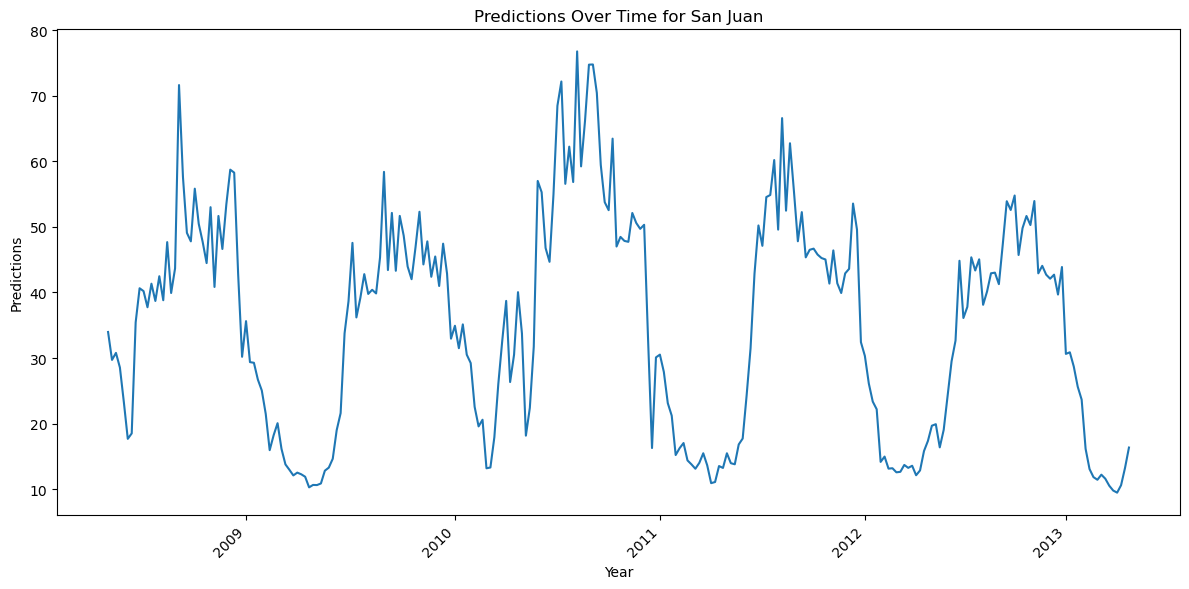

In [48]:
visualize_predictions(sj_test_predictions_series, "sj")

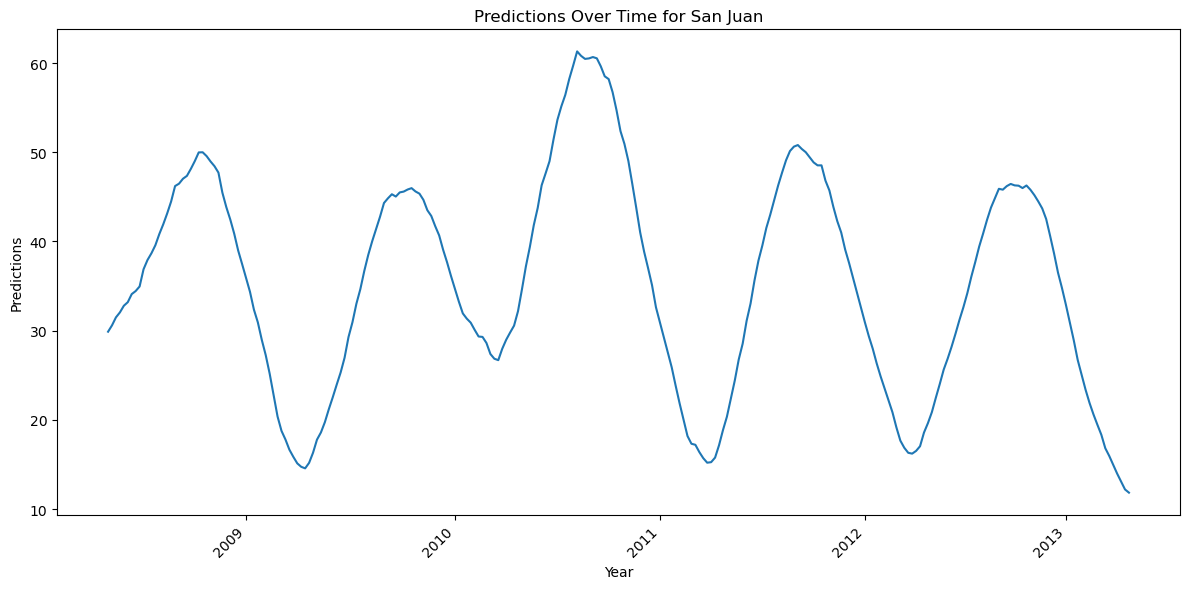

In [49]:
sj_test_predictions_series_ma = sj_test_predictions_series.rolling(window=20, center=True, min_periods=1).mean()

visualize_predictions(sj_test_predictions_series_ma, "sj")

In [50]:
# wasza czarna magia
# Extract indices for the second half of 2010 and 2011
second_half_2010 = sj_test_predictions_series[(sj_test_predictions_series.index.get_level_values('year') == 2009) & 
                                              (sj_test_predictions_series.index.get_level_values('weekofyear') >= 26)]
second_half_2011 = sj_test_predictions_series[(sj_test_predictions_series.index.get_level_values('year') == 2010) & 
                                              (sj_test_predictions_series.index.get_level_values('weekofyear') >= 26)]

# Swap the predictions
sj_test_predictions_series.loc[second_half_2010.index] = second_half_2011.values - 20
sj_test_predictions_series.loc[second_half_2011.index] = second_half_2010.values * 2

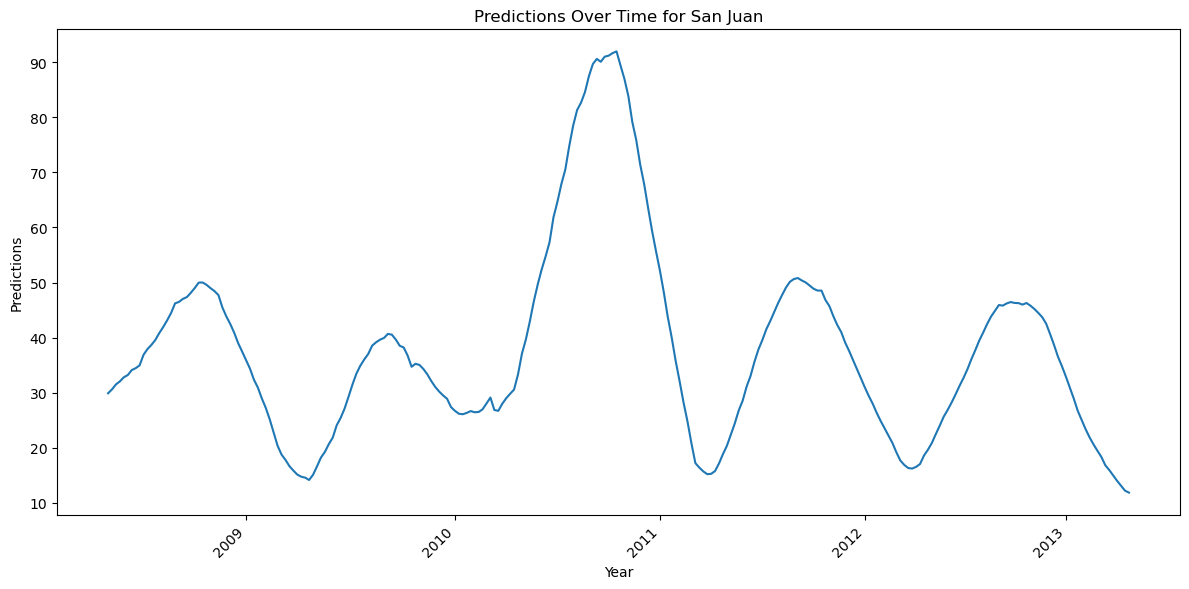

In [51]:
sj_test_predictions_series_ma = sj_test_predictions_series.rolling(window=20, center=True, min_periods=1).mean()

visualize_predictions(sj_test_predictions_series_ma, "sj")

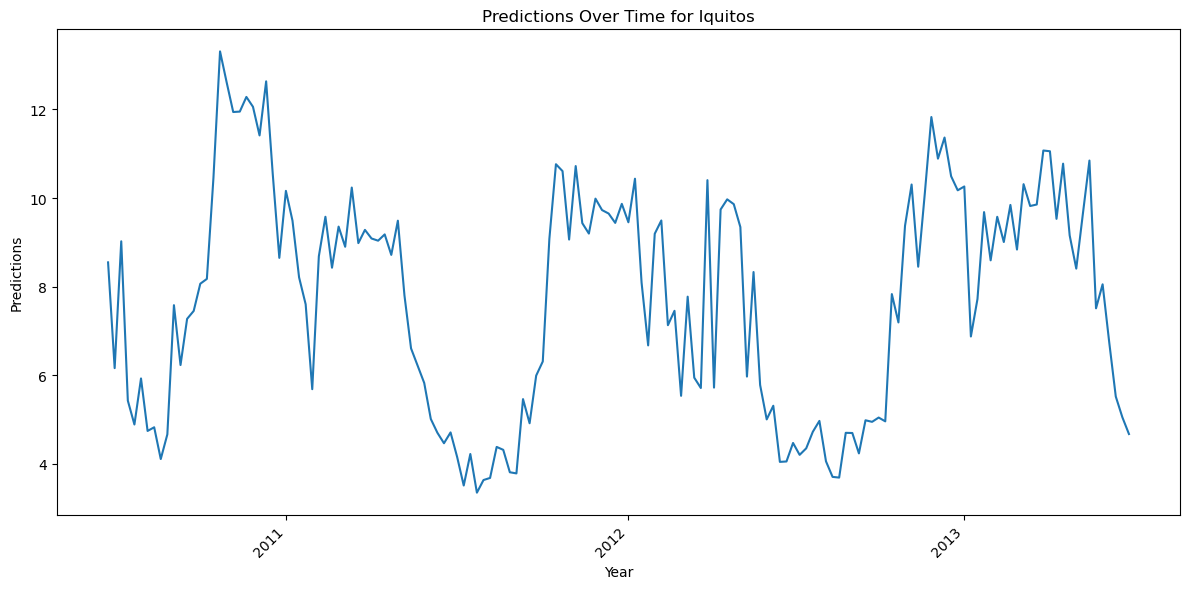

In [52]:
visualize_predictions(iq_test_predictions_series, "iq")

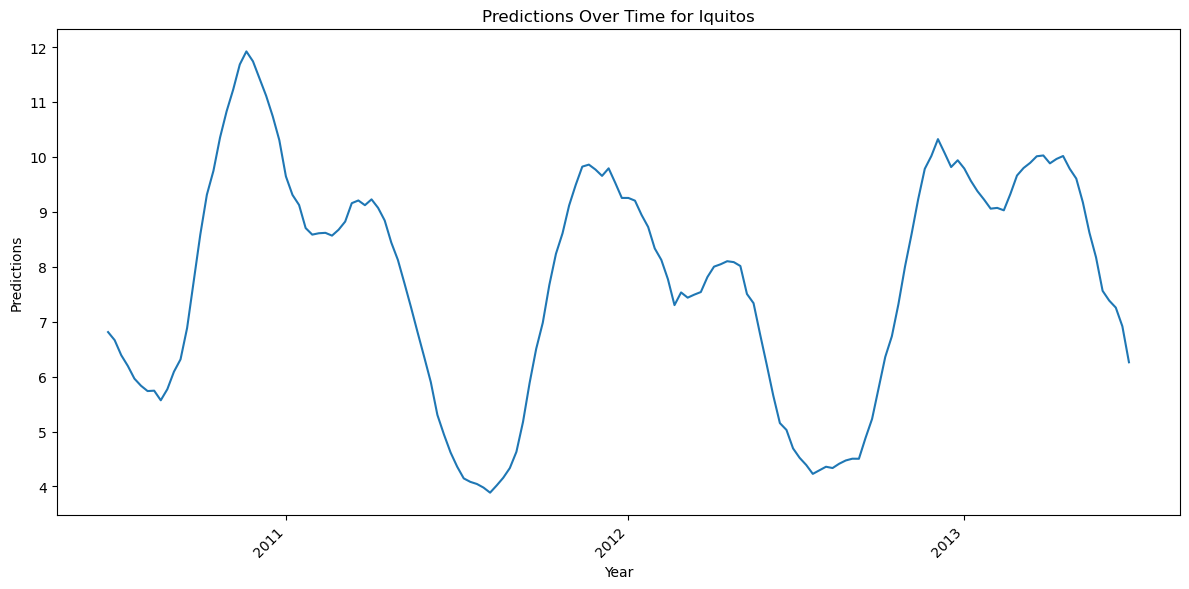

In [53]:
iq_test_predictions_series_ma = iq_test_predictions_series.rolling(window=10, min_periods=1, center=True).mean()

visualize_predictions(iq_test_predictions_series_ma, city='iq')

In [54]:
# wasza czarna magia
iq_np = iq_test_predictions_series_ma.values + 10 
quantile_75 = np.quantile(iq_np, 0.93)
iq_np = np.where(iq_np > quantile_75, iq_np * 2, iq_np)
iq_np = iq_np[::-1].round().astype(int)
iq_np

array([16, 17, 17, 17, 18, 18, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 41, 20, 20, 19, 19,
       18, 17, 17, 16, 16, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 15,
       15, 15, 15, 16, 16, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17,
       18, 17, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 19,
       19, 19, 18, 18, 17, 17, 16, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 16, 16, 17, 17, 18, 18, 18, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 41, 41, 42, 43, 43, 44, 43,
       42, 42, 41, 20, 19, 19, 18, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 17, 17])

In [55]:
sj_np = sj_test_predictions_series_ma.values.astype(int)
sj_np

array([29, 30, 31, 32, 32, 33, 34, 34, 34, 36, 37, 38, 39, 40, 41, 43, 44,
       46, 46, 47, 47, 48, 49, 49, 50, 49, 48, 48, 47, 45, 43, 42, 40, 38,
       37, 35, 34, 32, 30, 28, 27, 25, 22, 20, 18, 17, 16, 15, 15, 14, 14,
       14, 15, 16, 18, 19, 20, 21, 24, 25, 27, 29, 31, 33, 34, 36, 37, 38,
       39, 39, 39, 40, 40, 39, 38, 38, 36, 34, 35, 35, 34, 33, 32, 31, 30,
       29, 28, 27, 26, 26, 26, 26, 26, 26, 26, 26, 28, 29, 26, 26, 27, 28,
       29, 30, 33, 37, 39, 42, 46, 49, 52, 54, 57, 61, 64, 67, 70, 74, 78,
       81, 82, 84, 87, 89, 90, 90, 91, 91, 91, 91, 89, 86, 83, 79, 75, 71,
       67, 63, 59, 55, 52, 48, 43, 39, 35, 32, 28, 24, 20, 17, 16, 15, 15,
       15, 15, 17, 18, 20, 22, 24, 26, 28, 31, 33, 35, 37, 39, 41, 43, 44,
       46, 47, 49, 50, 50, 50, 50, 50, 49, 48, 48, 48, 46, 45, 43, 42, 41,
       39, 37, 35, 34, 32, 30, 29, 27, 26, 24, 23, 22, 20, 19, 17, 16, 16,
       16, 16, 17, 18, 19, 20, 22, 24, 25, 26, 28, 29, 31, 32, 34, 36, 37,
       39, 40, 42, 43, 44

In [30]:
from src.inference import create_submission

submission = create_submission(sj_np, iq_np, "../data/predictions/weather_lags.csv")

In [29]:
submission

,city,year,weekofyear,total_cases
0,sj,2008,18,33
1,sj,2008,19,32
2,sj,2008,20,33
3,sj,2008,21,32
4,sj,2008,22,31
...,...,...,...,...
411,iq,2013,22,14
412,iq,2013,23,15
413,iq,2013,24,15
414,iq,2013,25,15


In [56]:
from src.inference import create_submission

submission = create_submission(sj_np, iq_np, "../data/predictions/weather_lags_gs.csv")

In [57]:
submission

,city,year,weekofyear,total_cases
0,sj,2008,18,29
1,sj,2008,19,30
2,sj,2008,20,31
3,sj,2008,21,32
4,sj,2008,22,32
...,...,...,...,...
411,iq,2013,22,16
412,iq,2013,23,16
413,iq,2013,24,16
414,iq,2013,25,17


In [ ]:
# bez czarnej magii
sj_np_clean = sj_test_predictions_series.rolling(window=20, center=True, min_periods=1).mean().round().astype(int).values
iq_np_clean = iq_test_predictions_series.rolling(window=10, center=True, min_periods=1).mean().round().astype(int).values

# submission bez czarnej magii
from src.inference import create_submission

submission_clean = create_submission(sj_np_clean, iq_np_clean, "../data/predictions/weather_lags_clean.csv")

In [33]:
submission_clean

,city,year,weekofyear,total_cases
0,sj,2008,18,33
1,sj,2008,19,33
2,sj,2008,20,34
3,sj,2008,21,33
4,sj,2008,22,31
...,...,...,...,...
411,iq,2013,22,7
412,iq,2013,23,7
413,iq,2013,24,6
414,iq,2013,25,5


In [58]:
# bez czarnej magii
sj_np_clean = sj_test_predictions_series.rolling(window=20, center=True, min_periods=1).mean().round().astype(int).values
iq_np_clean = iq_test_predictions_series.rolling(window=10, center=True, min_periods=1).mean().round().astype(int).values

# submission bez czarnej magii
from src.inference import create_submission

submission_clean = create_submission(sj_np_clean, iq_np_clean, "../data/predictions/weather_lags_clean_gs.csv")

In [59]:
submission_clean

,city,year,weekofyear,total_cases
0,sj,2008,18,30
1,sj,2008,19,31
2,sj,2008,20,31
3,sj,2008,21,32
4,sj,2008,22,33
...,...,...,...,...
411,iq,2013,22,8
412,iq,2013,23,7
413,iq,2013,24,7
414,iq,2013,25,7
